# Applied PCA

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.widgets import Slider

%matplotlib notebook

## Helper Functions

In [2]:
def plot_data(data):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    ax.scatter(data[0,:], data[1,:], data[2,:])

def plot_data_with_orig(data, orig_fname):
    with open(orig_fname, 'rb') as f:
        data_orig = np.load(f)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    ax.scatter(data[0,:], data[1,:], data[2,:])
    ax.scatter(data_orig[0,:], data_orig[1,:], data_orig[2,:], color="red", alpha=0.3)

def plot_pcs(data, l, plane=True):
    assert l == 1 or l == 2
    Ul = find_principal_components(data, l)
    Ll = find_pc_magnitudes(data, l)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-20, 20])
    if plane:
        if l == 2:
            ax.scatter(data[0,:], data[1,:], data[2,:])
            normal = np.cross(Ul[:,0].squeeze(), Ul[:,1].squeeze())
            xx, yy = np.meshgrid(range(-10,10), range(-10,10))
            z = (-normal[0]*xx - normal[1]*yy)/normal[2]
            ax.plot_surface(xx,yy,z,color="red", alpha=0.5)
        if l == 1:
            ax.scatter(data[0,:], data[1,:], data[2,:])
            ax.plot([-20*Ul[0,0], 20*Ul[0,0]], [-12*Ul[1,0], 12*Ul[1,0]], zs=[-12*Ul[2,0], 12*Ul[2,0]], color="red")
    else:
        ax.scatter(data[0,:], data[1,:], data[2,:], alpha=0.2)
        origin = [0,0,0]
        for i in range(Ul.shape[1]):
            ax.quiver(0,0,0,Ll[i,i]*Ul[0,i],Ll[i,i]*Ul[1,i],Ll[i,i]*Ul[2,i],color="red",linewidth=3)

def diagonalize(X):
    lamb, U = np.linalg.eigh(X)
    idx = lamb.argsort()[::-1]
    lamb = lamb[idx]
    U = U[:,idx]
    L = np.diag(lamb)
    assert np.allclose(U @ L @ U.T, X)
    return U, L

def number_of_kb(data):
    return (data.size * data.itemsize)//1000

def plot_size_vs_acc(data, ls):
    sizes = []
    accuracies = []
    for l in ls:
        sizes.append(number_of_kb(compress_data(data, l)) + (data.shape[0] * l)*data.itemsize//1000)
        accuracies.append(measure_accuracy(data, l))
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel("Size of data (KB)")
    ax.set_ylabel("Reconstruction error")
    ax.plot(sizes, accuracies)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    ax2.set_xlabel("Number of Principal Components")
    ax2.set_ylabel("Size of data (KB)")
    ax2.plot(ls, sizes)

def get_de_meaned(X):
    return X - np.mean(X, axis=1)[:,np.newaxis]

## Applications of PCA

In this notebook, we will examine several use cases for PCA. First, write code to find the top $\ell$ principal components of any matrix $A$.

_HINT: Use the following function to diagonalize a matrix:_
```py
diagonalize(X):
'''
X: matrix to diagonalize

returns: (U, Lambda) where the diagonal components of Lambda are sorted in decreasing order
```

In [3]:
def find_principal_components(A, l):
    '''
    A: data matrix
    l: number of principal components to pick out
    
    returns: top l principal components of A
    '''
    U, L = diagonalize(A @ A.T)
    return U[:,:l]

### De-Noising Data

We can start by loading the data and plotting it below:

<IPython.core.display.Javascript object>


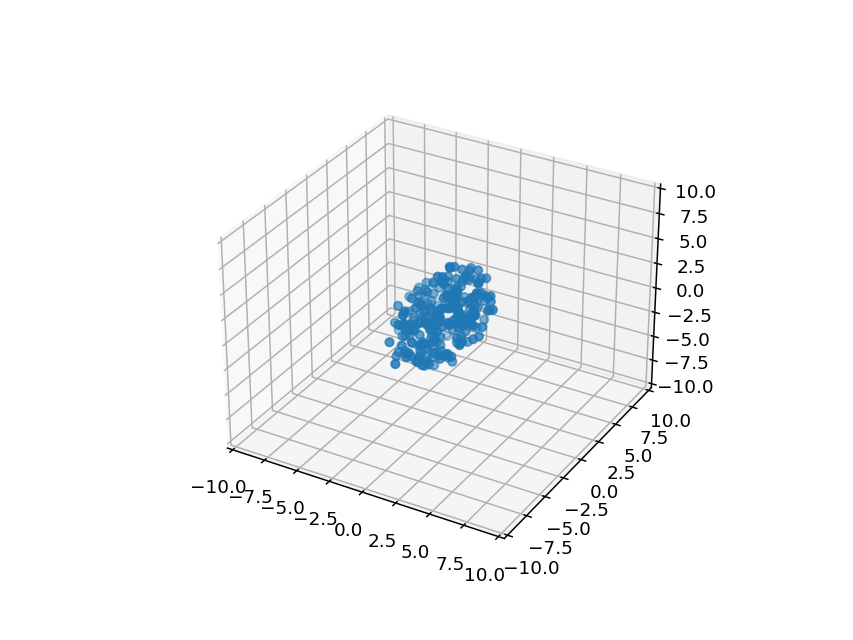

In [4]:
with open('data_noisy.npy', 'rb') as f:
    data_noisy = np.load(f)
plot_data(data_noisy)

Suppose we know that only two dimensions of this (three-dimensional) data are actually informative, and the remaining dimension is just noise. Note that we don't know exactly which dimensions are good and which is noisy. We can apply PCA to de-noise the data and select these informative dimensions. Write a function to de-noise the data.

_HINT: Note that $A \begin{bmatrix} \vec{x}_1 & \vec{x}_2 & \cdots & \vec{x}_n \end{bmatrix} = \begin{bmatrix} A \vec{x}_1 & A \vec{x}_2 & \cdots & A \vec{x}_n \end{bmatrix}$_

In [5]:
def de_noise(data, Ul):
    '''
    data: the data we want to de-noise
    Ul: the top l principal components of the data
    
    returns: de-noised data
    '''
    return Ul @ Ul.T @ data

Choose the top $\ell = 2$ principal components to de-noise the data. Plot it using the `plot_data` function:
```py
plot_data(data):
'''
data: the data to plot with a scatter plot

returns: a scatter plot of the data
'''
```

<IPython.core.display.Javascript object>


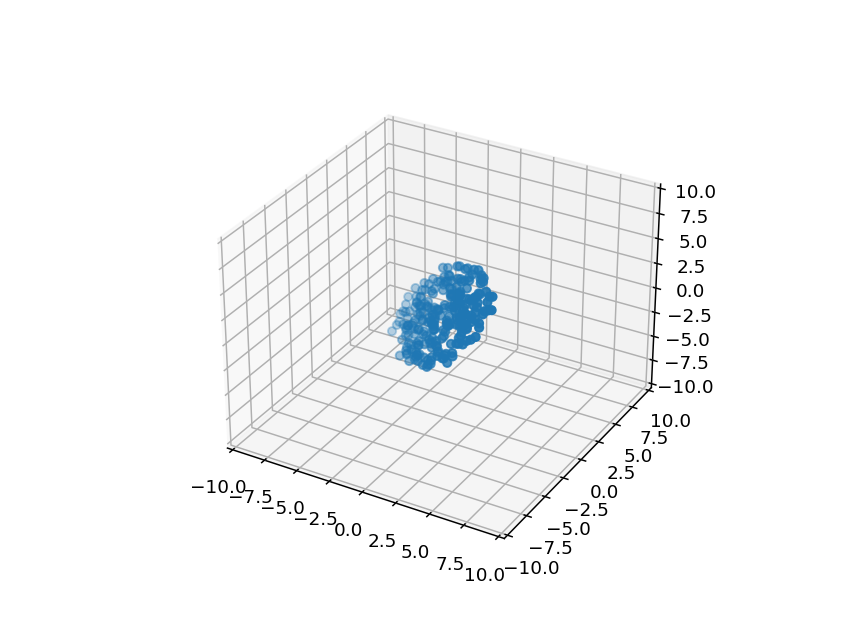

In [6]:
U2 = find_principal_components(data_noisy, 2)
de_noised_data = de_noise(data_noisy, U2)
plot_data(de_noised_data)

The data is now much less noisy! The ability for PCA to remove small amounts of noise like this makes it very valuable in data science applications, including system ID. We can also plot the de-noised data against the original data without the noise:

<IPython.core.display.Javascript object>


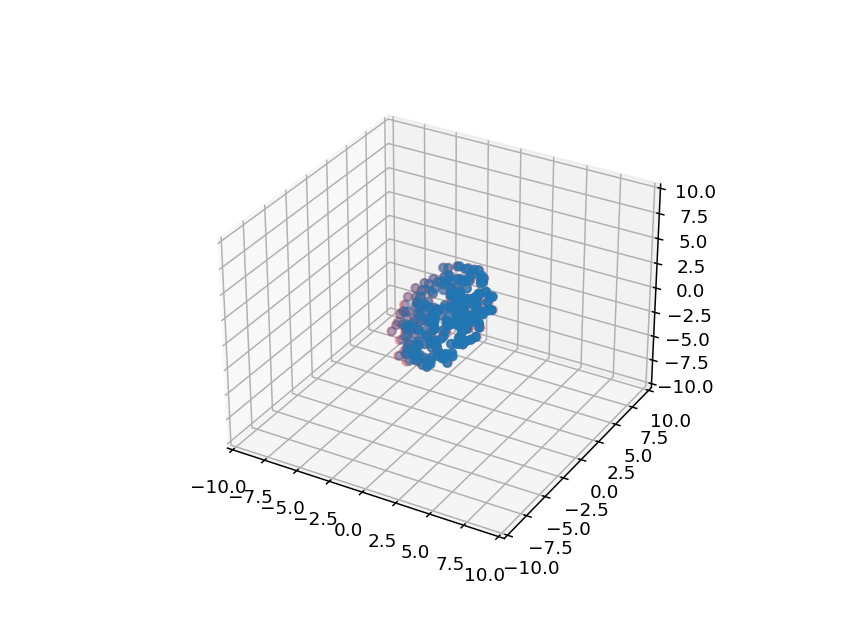

In [7]:
plot_data_with_orig(de_noised_data, 'data_orig.npy')

As we can see, PCA has done quite a good job of recovering the original data.

### Data Compression

We can start by loading the data and determining its dimensionality and size (in bytes)

In [8]:
with open('data_large.npy', 'rb') as f:
    data_large = np.load(f)
print("Data dimensionality:", data_large.shape[0])
print("Size of data (in KB):", number_of_kb(data_large))

Data dimensionality: 20
Size of data (in KB): 80


We can also use PCA to compress high-dimensional data. Write a function to compress the data matrix to $\ell$ dimensions.

In [9]:
def compress_data(data, l):
    '''
    data: the data matrix
    l: the desired dimensionality of the data
    
    returns: l-dimensional data
    '''
    Ul = find_principal_components(data, l)
    return Ul.T @ data

We would like to measure the reconstruction error (i.e. the "closeness") of the $\ell$-dimensional approximation to the original data. Write a function to compute the reconstruction error.

_HINT: Recall how we motivated the idea of best rank-$\ell$ approximation of a matrix. How did we define "best"?_

In [10]:
def measure_accuracy(data, l):
    '''
    data: the data matrix
    l: the dimensionality of the approximation
    
    returns: accuracy of the l-dimensional approximation
    '''
    Ul = find_principal_components(data, l)
    return np.linalg.norm(data - Ul @ Ul.T @ data)

We can now compute the size (in bytes) of the $\ell$-dimensional approximation, for some values of $\ell$ of our choosing. We can then plot size vs reconstruction error. Note that our data is 20-dimensional, so we need to choose $\ell \leq 20$.

<IPython.core.display.Javascript object>


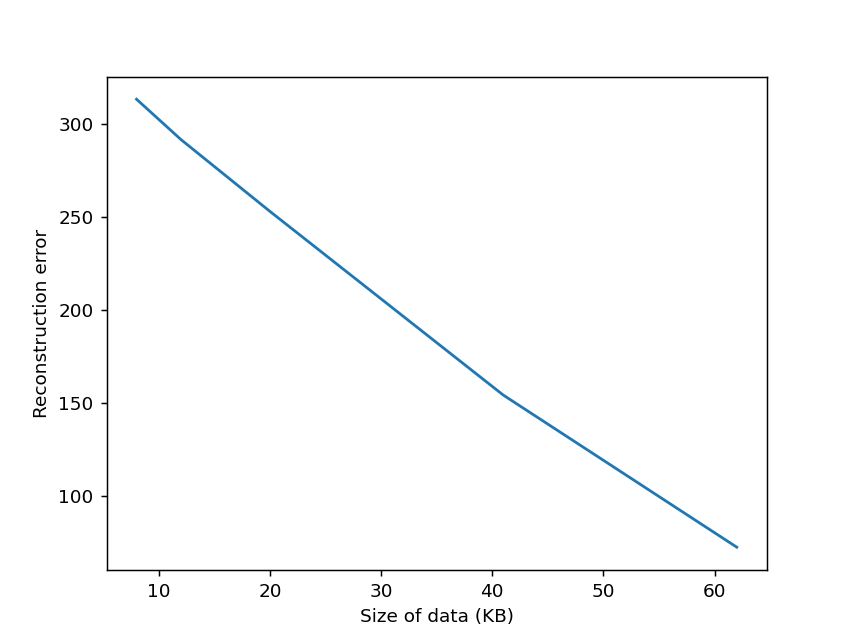

<IPython.core.display.Javascript object>


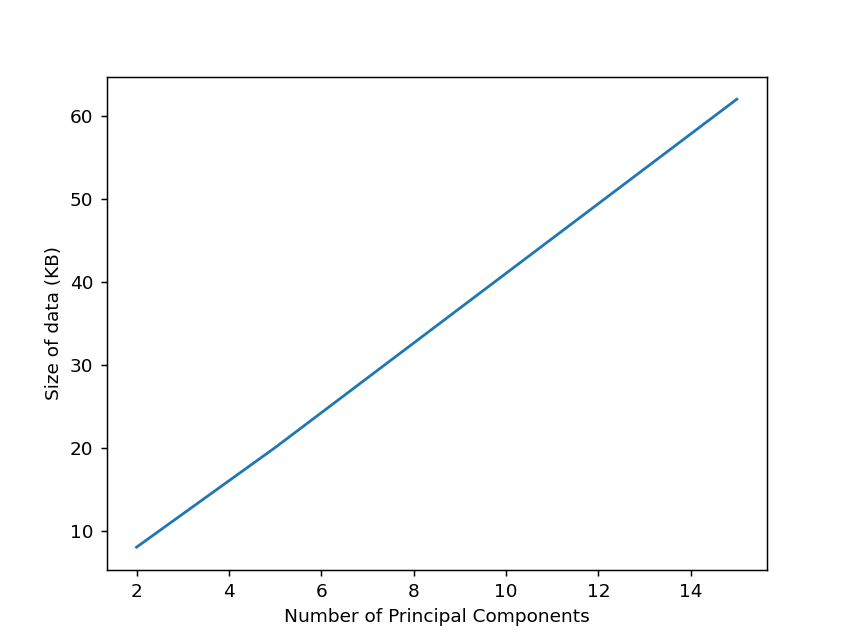

In [11]:
ls = [2, 3, 5, 10, 15] # Feel free to change this list!
plot_size_vs_acc(data_large, ls)

As we can see, a larger matrix overall will result in a better approximation. However, we can get a fairly decent approximation even with half the size (e.g. 40 KB). Note that, by using this method, you still have to store the $U_\ell$ matrix, but this storage cost included in the plot above.

The idea is very important when performing matrix multiplications on devices that don't have a lot of memory, e.g. your TI Launchpad. However, note that, when you are performing matrix multiplications in these instances, you'd want to use the following order of operations: $$U_\ell \left(U_\ell^\top \vec{x}\right)$$ where $\vec{x}$ is the vector you are trying to multiply.

### [OPTIONAL] Directions of Variance

This is an optional section that follows up on question 1.e of the associated discussion worksheet. The goal is to investigate why centering our data is important when we want to associate principal components with directions of maximal spread of our data. Much of the mathematical reasoning behind this relies on some statistics, so it remains optional and out of scope.

We start by loading our data:

In [12]:
with open('data_var.npy', 'rb') as f:
    data_var = np.load(f)

The task here is to find the directions of the data with largest variance. We can observe the magnitude of the principal components, i.e. the top $\ell$ eigenvalues of $\frac{1}{N - 1} A A^\top$, where $N$ is the number of data points we have. Here, we require that $A$ is zero-mean (i.e. each row of $A$ is zero-mean). We will see why this is the case, by visually comparing the results if we de-mean (i.e. subtract out the mean of all the data points from each data point) and don't de-mean. The ideas behind de-meaning, dividing by $\frac{1}{N - 1}$, and using principal components to find directions of "variance" are rooted in statistics and hence out of the scope of this course.

First, write a function to find the top $\ell$ eigenvalues of $\frac{1}{N - 1} A A^\top$.

In [13]:
def find_pc_magnitudes(A, l):
    '''
    A: data matrix
    l: number of principal component magnitudes
    
    returns: magnitude of top l principal components
    '''
    U, L = diagonalize((1/(A.shape[1] - 1)) * A @ A.T)
    return L[:l,:l]

Note that we don't need to rewrite our code to find principal components, since the eigenvectors of $A A^\top$ will not change if you multiply by a $\frac{1}{N - 1}$ scaling factor.

Use the following function
```py
plot_pcs(data, Ul, Ll):
'''
data: the given data points
Ul: the top l PCs
Ll: the top l eigenvalues

returns: a scatter plot of the data with scaled PC vectors
'''
```
to plot the principal components with their respective magnitudes. First, de-mean the data and plot the principal components. Compare this plot with the plot of the original data.

_HINT: Use the following function to de-mean your data:_

```py
get_de_meaned(X):
'''
X: data matrix

returns: de-meaned data matrix
'''
```

#### De-Meaned Data:

<IPython.core.display.Javascript object>


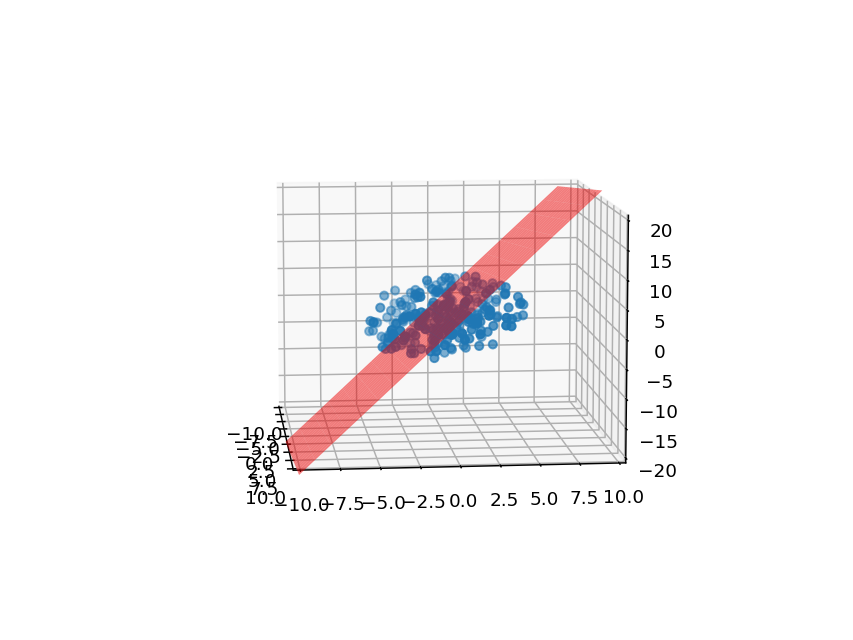

In [14]:
l = 2 # change this to any value in {1, 2}
draw_plane = False # change this to True if you just want to visualize directions
de_meaned_data = get_de_meaned(data_var)
plot_pcs(de_meaned_data, l, plane=draw_plane)

We see that de-meaning the data is informative here for visualizing the directions of variance (and their relative magnitudes) in the data.

#### Original Data:

<IPython.core.display.Javascript object>


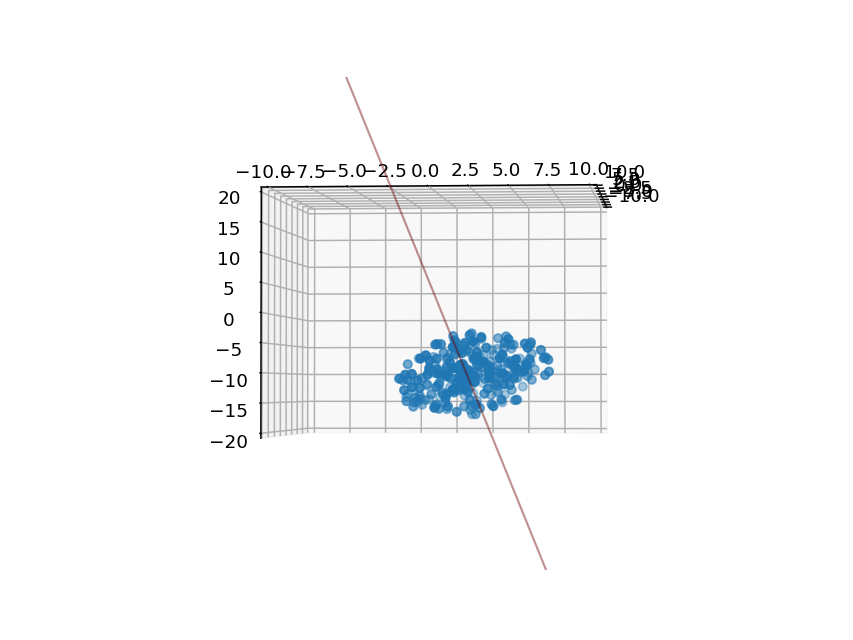

In [15]:
draw_plane = False # change this to True if you just want to visualize directions
plot_pcs(data_var, l, plane=draw_plane)

As you may notice, these arrows do not make much sense in terms of describing the variance (i.e., "shape") of the data when plotted. Also, notice how they are offset from the center of the data. De-meaning will allow us to use the principal components to better interpret the variance of the data.

**Contributors**
- Anish Muthali